In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.feature_extraction import FeatureHasher

In [2]:
def impute_invalid_with_similar(df):
  similar_found = 0
  non_similar_found = 0

  # Iterate through rows with missing values in the specified column
  for idx, row in df[df['mileage'] == '0.0 kmpl'].iterrows():
    # Define similar vehicle condition
    similar_condition = (df['name'] == row['name']) & (df['year'] == row['year']) & (df['fuel'] == row['fuel'])
    similar_vehicles = df[similar_condition]

    if not similar_vehicles.empty:
      df.at[idx, 'mileage'] = similar_vehicles['mileage'].iloc[0]
      similar_found += 1
    else:
      non_similar_found += 1

  for idx, row in df[(df['max_power'].isin(['bhp', '0']))].iterrows():
    # Define similar vehicle condition
    similar_condition = (df['name'] == row['name']) & (df['year'] == row['year']) & (df['fuel'] == row['fuel'])
    similar_vehicles = df[similar_condition]

    if not similar_vehicles.empty:
      df.at[idx, 'max_power'] = similar_vehicles['max_power'].iloc[0]
      similar_found += 1
    else:
      non_similar_found += 1

  print(f"Imputing {similar_found} vehicles with similarities")
  print(f"Imputing {non_similar_found} vehicles with non similarities")
  return df

In [3]:
import re

def standardize_torque(torque_str):
    if pd.isna(torque_str):
        return np.nan

    # Regex patterns for different torque formats
    patterns = [
        # Pattern to match: value, optional unit, @, rpm
        r"(\d*\.?\d+)\s*(kgm|nm)?\s*@\s*([-\d\s,]+)\s*(rpm)?",
        # Pattern to match: value, optional unit, at, rpm
        r"(\d*\.?\d+)\s*(kgm|nm)?\s*at\s*([-\d\s,]+)\s*(rpm)?",
        # Pattern to match: value in kgm with parentheses around rpm
        r"(\d*\.?\d+)\s*@\s*([-\d\s,]+)\s*\(kgm@\s*rpm\)",
        # Pattern to match: kgm value followed by at and rpm
        r"(\d*\.?\d+)\s*kgm\s*at\s*([-\d\s,]+)\s*(rpm)?",
        # Pattern to match: value (value in kgm), optional unit, @, rpm
        r"(\d*\.?\d+)\s*\((\d*\.?\d+)\s*kgm\)\s*@\s*([-\d\s,]+)\s*(rpm)?",
        # Pattern to match: value, optional kgm in parentheses
        r"(\d*\.?\d+)\s*\((\d*\.?\d+)\)\s*@\s*([-\d\s,]+)\s*(rpm)?",
        # Pattern to match: value, optional unit, /, rpm
        r"(\d*\.?\d+)\s*(kgm|nm)?\s*/\s*([-\d\s,]+)\s*(rpm)?",
        # Pattern to match: value / rpm with no units
        r"(\d*\.?\d+)\s*/\s*([-\d\s,]+)"
    ]

    # Initialize default values
    torque_value = None
    rpm_value = None

    for pattern in patterns:
        match = re.findall(pattern, torque_str.lower())
        if match:
            # Determine the number of groups matched and unpack accordingly
            if len(match[0]) == 4:
                value, unit, rpm_range, _ = match[0]
            elif len(match[0]) == 3:
                value, unit, rpm_range = match[0]
            elif len(match[0]) == 2:
                value, rpm_range = match[0]
                unit = None
            else:
                continue

            # Convert value to float
            value = float(value)

            # Convert kgm to Nm if necessary
            if 'kgm' in torque_str.lower() or (unit and 'kgm' in unit):
                value *= 9.81  # Convert kgm to Nm

            # Format torque value to 2 decimal places
            torque_value = f"{value:.2f}Nm"

            # Clean and format the rpm_range
            rpm_value = rpm_range.strip().replace(',', '').replace(' ', '')

            break  # Stop after first match

    # Combine torque and RPM value
    if torque_value:
        if rpm_value:
            return f"{torque_value} {rpm_value}rpm"
        else:
            return torque_value  # Return only the torque value if no RPM is found

    # If no valid torque value is found, return torque
    print(f"Returning original torque value {torque_str}")
    return torque_str

# Example usage
example_data = [
    "96 Nm at 3000 rpm",
    "14.9 KGM at 3000 RPM",
    "180 Nm at 1440-1500rpm",
    "400Nm",
    "12.7@ 2,700(kgm@ rpm)",
    "7.8@ 4,500(kgm@ rpm)"
]

for torque in example_data:
    print(f"{torque}: {standardize_torque(torque)}")

96 Nm at 3000 rpm: 96.00Nm 3000rpm
14.9 KGM at 3000 RPM: 146.17Nm 3000rpm
180 Nm at 1440-1500rpm: 180.00Nm 1440-1500rpm
Returning original torque value 400Nm
400Nm: 400Nm
12.7@ 2,700(kgm@ rpm): 124.59Nm 2700rpm
7.8@ 4,500(kgm@ rpm): 76.52Nm 4500rpm


In [4]:
def impute_nulls_with_similar(df):
    # Ensure 'name' and 'year' have non-null values
    df['name'] = df['name'].fillna('Unknown')
    df['year'] = df['year'].fillna(df['year'].mode()[0])
    
    # Columns to impute
    impute_cols = ['mileage', 'engine', 'max_power', 'torque', 'seats']
    
    # Create a filtration mask for missing values
    null_mask = df[impute_cols].isnull().any(axis=1)
    # Create a new column to indicate imputation
    df['imputed_by_similar'] = 0
    
    for idx, row in df[null_mask].iterrows():
        # Find similar vehicles based on name, year, and fuel (if fuel is not null)
        similar_condition = (df['name'] == row['name']) & (df['year'] == row['year']) & (df['fuel'] == row['fuel'])
        similar_vehicles = df[similar_condition]
    
        if not similar_vehicles.empty:
            # Impute with the closest vehicle's value for missing columns
            for col in impute_cols:
                if pd.isnull(row[col]):
                    if not similar_vehicles[similar_vehicles[col].notnull()].empty:
                        # Set the first non-null value to the 'imputed_value' variable
                        imputed_value = similar_vehicles[similar_vehicles[col].notnull()][col].iloc[0]
                        print(f"imputed_value: {imputed_value}")
                        df.at[idx, col] = imputed_value
                        df.at[idx, 'imputed_by_similar'] = 1

    return df

In [5]:
car_details_v3  = pd.read_csv('../datasets/Car details v3.csv')

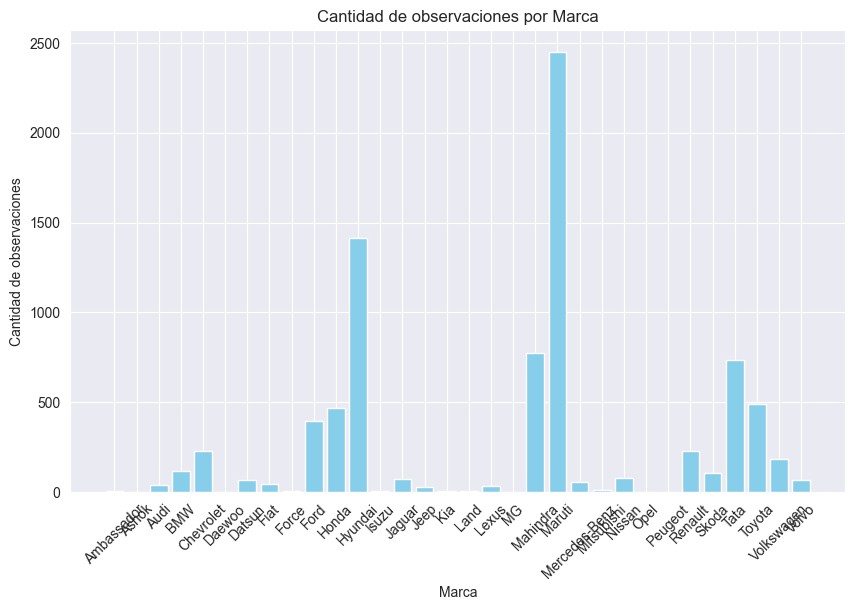

array(['Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Tata', 'Chevrolet', 'Fiat', 'Datsun', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Ashok', 'Isuzu', 'Opel', 'Peugeot'],
      dtype=object)

In [6]:
car_details_v3[['make', 'model']] = car_details_v3['name'].str.split(' ', n=1, expand=True)
make_counts = car_details_v3['make'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(make_counts.index, make_counts.values, color='skyblue')
plt.xlabel('Marca')
plt.ylabel('Cantidad de observaciones')
plt.title('Cantidad de observaciones por Marca')
plt.xticks(rotation=45)
plt.show()

car_details_v3['make'].unique()

In [7]:
car_details_v3 = impute_invalid_with_similar(car_details_v3)

Imputing 23 vehicles with similarities
Imputing 0 vehicles with non similarities


In [8]:
missing_values = car_details_v3.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

Feature: name - Missing values: 0
Feature: year - Missing values: 0
Feature: selling_price - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: fuel - Missing values: 0
Feature: seller_type - Missing values: 0
Feature: transmission - Missing values: 0
Feature: owner - Missing values: 0
Feature: mileage - Missing values: 221
Feature: engine - Missing values: 221
Feature: max_power - Missing values: 215
Feature: torque - Missing values: 222
Feature: seats - Missing values: 221
Feature: make - Missing values: 0
Feature: model - Missing values: 0


In [9]:
car_details_v3 = impute_nulls_with_similar(car_details_v3)

car_details_v3

imputed_value: 20.92 kmpl
imputed_value: 998 CC
imputed_value: 90Nm@ 3500rpm
imputed_value: 5.0
imputed_value: 20.92 kmpl
imputed_value: 998 CC
imputed_value: 90Nm@ 3500rpm
imputed_value: 5.0
imputed_value: 26.59 kmpl
imputed_value: 1248 CC
imputed_value: 190Nm@ 2000rpm
imputed_value: 5.0
imputed_value: 26.59 kmpl
imputed_value: 1248 CC
imputed_value: 190Nm@ 2000rpm
imputed_value: 5.0
imputed_value: 25.2 kmpl
imputed_value: 1248 CC
imputed_value: 74 bhp
imputed_value: 190Nm@ 2000rpm
imputed_value: 5.0
imputed_value: 22.3 kmpl
imputed_value: 1248 CC
imputed_value: 190Nm@ 1750-3000rpm
imputed_value: 5.0
imputed_value: 22.3 kmpl
imputed_value: 1248 CC
imputed_value: 190Nm@ 1750-3000rpm
imputed_value: 5.0
imputed_value: 25.2 kmpl
imputed_value: 1248 CC
imputed_value: 74 bhp
imputed_value: 190Nm@ 2000rpm
imputed_value: 5.0
imputed_value: 25.2 kmpl
imputed_value: 1248 CC
imputed_value: 74 bhp
imputed_value: 190Nm@ 2000rpm
imputed_value: 5.0
imputed_value: 25.2 kmpl
imputed_value: 1248 CC
imp

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,make,model,imputed_by_similar
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,Skoda,Rapid 1.5 TDI Ambition,0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,Honda,City 2017-2020 EXi,0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0,Hyundai,i20 Sportz Diesel,0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0,Maruti,Swift VXI BSIII,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0,Hyundai,i20 Magna,0
8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0,Hyundai,Verna CRDi SX,0
8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire ZDi,0
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0,Tata,Indigo CR4,0


In [10]:
missing_values = car_details_v3.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

car_details_v3[car_details_v3['imputed_by_similar'] == 1]

Feature: name - Missing values: 0
Feature: year - Missing values: 0
Feature: selling_price - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: fuel - Missing values: 0
Feature: seller_type - Missing values: 0
Feature: transmission - Missing values: 0
Feature: owner - Missing values: 0
Feature: mileage - Missing values: 208
Feature: engine - Missing values: 208
Feature: max_power - Missing values: 208
Feature: torque - Missing values: 209
Feature: seats - Missing values: 208
Feature: make - Missing values: 0
Feature: model - Missing values: 0
Feature: imputed_by_similar - Missing values: 0


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,make,model,imputed_by_similar
575,Maruti Alto K10 LXI,2011,204999,97500,Petrol,Individual,Manual,First Owner,20.92 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0,Maruti,Alto K10 LXI,1
576,Maruti Alto K10 LXI,2011,204999,97500,Petrol,Individual,Manual,First Owner,20.92 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0,Maruti,Alto K10 LXI,1
1442,Maruti Swift Dzire VDI Optional,2017,589000,41232,Diesel,Dealer,Manual,First Owner,26.59 kmpl,1248 CC,0,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI Optional,1
1443,Maruti Swift Dzire VDI Optional,2017,589000,41232,Diesel,Dealer,Manual,First Owner,26.59 kmpl,1248 CC,0,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI Optional,1
2356,Maruti Swift VDI BSIV,2011,295000,50000,Diesel,Individual,Manual,First Owner,25.2 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,Maruti,Swift VDI BSIV,1
2549,Tata Indica Vista Quadrajet LS,2012,240000,70000,Diesel,Individual,Manual,First Owner,22.3 kmpl,1248 CC,0,190Nm@ 1750-3000rpm,5.0,Tata,Indica Vista Quadrajet LS,1
2550,Tata Indica Vista Quadrajet LS,2012,240000,70000,Diesel,Individual,Manual,First Owner,22.3 kmpl,1248 CC,0,190Nm@ 1750-3000rpm,5.0,Tata,Indica Vista Quadrajet LS,1
2551,Maruti Swift VDI BSIV,2011,320000,120000,Diesel,Individual,Manual,Second Owner,25.2 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,Maruti,Swift VDI BSIV,1
3173,Maruti Swift VDI BSIV,2017,525000,38000,Diesel,Dealer,Manual,Second Owner,25.2 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,Maruti,Swift VDI BSIV,1
3813,Maruti Swift VDI BSIV,2011,340000,160000,Diesel,Individual,Manual,Second Owner,25.2 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,Maruti,Swift VDI BSIV,1


In [11]:
missing_values = car_details_v3.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

Feature: name - Missing values: 0
Feature: year - Missing values: 0
Feature: selling_price - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: fuel - Missing values: 0
Feature: seller_type - Missing values: 0
Feature: transmission - Missing values: 0
Feature: owner - Missing values: 0
Feature: mileage - Missing values: 208
Feature: engine - Missing values: 208
Feature: max_power - Missing values: 208
Feature: torque - Missing values: 209
Feature: seats - Missing values: 208
Feature: make - Missing values: 0
Feature: model - Missing values: 0
Feature: imputed_by_similar - Missing values: 0


In [12]:
# Limpiar y convertir 'mileage' a numérico
mileage_non_null = car_details_v3[car_details_v3['mileage'].notnull()].copy()
car_details_v3['mileage_as_number'] = mileage_non_null['mileage'].str.replace(r'[^0-9.]+', '', regex=True)
car_details_v3['mileage_as_number'] = pd.to_numeric(car_details_v3['mileage_as_number'], errors='coerce')

In [13]:
# Limpiar y convertir 'engine' a numérico
engine_non_null = car_details_v3[car_details_v3['engine'].notnull()].copy()
car_details_v3['engine_as_number'] = engine_non_null['engine'].str.replace(r'[^0-9.]+', '', regex=True)
car_details_v3['engine_as_number'] = pd.to_numeric(car_details_v3['engine_as_number'], errors='coerce')

In [14]:
# Limpiar y convertir 'max_power' a numérico
max_power_non_null = car_details_v3[car_details_v3['max_power'].notnull()].copy()
car_details_v3['max_power_as_number'] = mileage_non_null['max_power'].str.replace(r'[^0-9.]+', '', regex=True)
car_details_v3['max_power_as_number'] = pd.to_numeric(car_details_v3['max_power_as_number'], errors='coerce')

In [15]:
car_details_v3['torque_standardized'] = car_details_v3['torque'].apply(standardize_torque)
car_details_v3['torque_standardized'] = car_details_v3['torque_standardized']

Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 380Nm(38.7kgm)@ 2500rpm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 400Nm
Returning original torque value 

In [16]:
car_details_v3.loc[
    car_details_v3['torque'].notnull() & car_details_v3['torque_standardized'].isnull(),
    ['torque', 'torque_standardized']
]

,torque,torque_standardized


In [17]:
missing_values = car_details_v3.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

Feature: name - Missing values: 0
Feature: year - Missing values: 0
Feature: selling_price - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: fuel - Missing values: 0
Feature: seller_type - Missing values: 0
Feature: transmission - Missing values: 0
Feature: owner - Missing values: 0
Feature: mileage - Missing values: 208
Feature: engine - Missing values: 208
Feature: max_power - Missing values: 208
Feature: torque - Missing values: 209
Feature: seats - Missing values: 208
Feature: make - Missing values: 0
Feature: model - Missing values: 0
Feature: imputed_by_similar - Missing values: 0
Feature: mileage_as_number - Missing values: 208
Feature: engine_as_number - Missing values: 208
Feature: max_power_as_number - Missing values: 209
Feature: torque_standardized - Missing values: 209


In [18]:
# car_details_v3 = pd.get_dummies(car_details_v3, columns=['fuel', 'name', 'transmission', 'seller_type', 'owner'], drop_first=True)

# car_details_v3 = car_details_v3.drop(columns=['mileage', 'engine', 'max_power', 'torque'])

In [21]:
def hashing_encoding(df, cols, data_percent=0.85, verbose=False):
    for i in cols:
        val_counts = df[i].value_counts(dropna=False)
        s = sum(val_counts.values)
        h = val_counts.values / s
        c_sum = np.cumsum(h)
        c_sum = pd.Series(c_sum)
        n = c_sum[c_sum > data_percent].index[0]
        if verbose:
            print("n hashing para ", i, ":", n)
        if n > 0:
            fh = FeatureHasher(n_features=n, input_type='string')
            hashed_features = fh.fit_transform(
                df[i].astype(str).values.reshape(-1, 1)
            ).todense()
            df = df.join(pd.DataFrame(hashed_features).add_prefix(i + '_'))

    return df.drop(columns=cols)

def knn_imputer(df):

    cat_cols = ['make', 'model', 'fuel', 'transmission', 'seller_type', 'owner']

    # Aplicamos hashing para las categoricas
    df = hashing_encoding(df, cat_cols)

    # Eliminamos name y alignment para imputar
    df = df.drop(columns=['mileage', 'engine', 'max_power', 'torque', 'name', 'torque_standardized'])

    # definimos un n arbitrario
    imputer = KNNImputer(n_neighbors=5, weights="uniform")

    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df

car_details_v3['imputed_by_knn'] = car_details_v3['mileage_as_number'].isnull().astype(int)

columns_to_impute = ['mileage_as_number', 'engine_as_number', 'max_power_as_number', 'seats']
car_details_v3[columns_to_impute] = knn_imputer(car_details_v3)[columns_to_impute]
car_details_v3['imputed_by_knn'] = car_details_v3['imputed_by_knn'] | car_details_v3['mileage_as_number'].isnull().astype(int)

In [23]:
car_details_v3

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,...,torque,seats,make,model,imputed_by_similar,mileage_as_number,engine_as_number,max_power_as_number,torque_standardized,imputed_by_knn
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,...,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,0,23.40,1248.0,74.00,190.00Nm 2000rpm,0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,...,250Nm@ 1500-2500rpm,5.0,Skoda,Rapid 1.5 TDI Ambition,0,21.14,1498.0,103.52,250.00Nm 1500-2500rpm,0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,...,"12.7@ 2,700(kgm@ rpm)",5.0,Honda,City 2017-2020 EXi,0,17.70,1497.0,78.00,124.59Nm 2700rpm,0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,...,22.4 kgm at 1750-2750rpm,5.0,Hyundai,i20 Sportz Diesel,0,23.00,1396.0,90.00,219.74Nm 1750-2750rpm,0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,...,"11.5@ 4,500(kgm@ rpm)",5.0,Maruti,Swift VXI BSIII,0,16.10,1298.0,88.20,112.82Nm 4500rpm,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,...,113.7Nm@ 4000rpm,5.0,Hyundai,i20 Magna,0,18.50,1197.0,82.85,113.70Nm 4000rpm,0
8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,...,"24@ 1,900-2,750(kgm@ rpm)",5.0,Hyundai,Verna CRDi SX,0,16.80,1493.0,110.00,235.44Nm 1900-2750rpm,0
8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,...,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire ZDi,0,19.30,1248.0,73.90,190.00Nm 2000rpm,0
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,...,140Nm@ 1800-3000rpm,5.0,Tata,Indigo CR4,0,23.57,1396.0,70.00,140.00Nm 1800-3000rpm,0


In [24]:
missing_values = car_details_v3.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

Feature: name - Missing values: 0
Feature: year - Missing values: 0
Feature: selling_price - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: fuel - Missing values: 0
Feature: seller_type - Missing values: 0
Feature: transmission - Missing values: 0
Feature: owner - Missing values: 0
Feature: mileage - Missing values: 208
Feature: engine - Missing values: 208
Feature: max_power - Missing values: 208
Feature: torque - Missing values: 209
Feature: seats - Missing values: 0
Feature: make - Missing values: 0
Feature: model - Missing values: 0
Feature: imputed_by_similar - Missing values: 0
Feature: mileage_as_number - Missing values: 0
Feature: engine_as_number - Missing values: 0
Feature: max_power_as_number - Missing values: 0
Feature: torque_standardized - Missing values: 209
Feature: imputed_by_knn - Missing values: 0
